In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
import json

In [2]:
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96 // 8}
vit_era5 = {'l': 64800, 'e': 2048, 'h': 64, 'depth': 24}
### model
model = gpt3
b = 1
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

model: batch size = 1, seq length = 2048, embed = 12288, attention heads = 256, depth = 96


In [3]:
with open('config.json', 'r') as file:
    system = json.load(file)

In [4]:
def print_df(df_mlp, df_sa):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    display(df_mlp[cols])
    display(df_mlp[layer_track_cols].sum() * depth)
    display(df_sa[cols])
    display(df_sa[layer_track_cols].sum() * depth)
    t_itr = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() + df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
    print('time for 1 itr = {}'.format(t_itr))

    f1 = 3 # 1 fp16 wt, 1 fp32 copy
    f2 = 5 # 1 fp16 grad, 2 fp32 means and variances
    mem = (df_mlp['weights_mem'].sum() * f1 + df_mlp['weights_grad_mem'].sum() * f2 + df_mlp['activation_buffer'].sum() +
           df_sa['weights_mem'].sum() * f1 + df_sa['weights_grad_mem'].sum() * f2 + df_sa['activation_buffer'].sum()) * depth
    print('mem consumed = {}'.format(mem))

In [5]:
m1 = 64
system['nvlink_size'] = 8
t1 = 'nvlink' if m1 <= system['nvlink_size'] else 'ib'
df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1})
df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=False)
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,0.018874,0.018874,3.865313e-02,0.050332,0.000000,reducescatter,7.727481e-02,0.050332,reducescatter,0.123888,0.000000,2.662634,0.750992,0.503316,2.661551,0.874880
1,fc1-bias,0.000002,0.000002,1.572864e-06,0.000000,0.000000,none,1.572864e-06,0.000000,allreduce,0.002024,0.000000,0.009963,0.002024,0.000000,0.009963,0.004048
2,act1,0.000000,0.000000,1.572864e-06,0.003146,0.000000,none,1.572864e-06,0.000000,none,0.004046,0.000000,0.004984,0.006069,0.000000,0.003323,0.010115
3,dpr1,0.000000,0.000000,1.572864e-06,0.001573,0.000000,none,1.572864e-06,0.000000,none,0.005057,0.000000,0.003987,0.005057,0.000000,0.003987,0.010115
4,fc2,0.018874,0.018874,3.862954e-02,0.003146,0.050332,reducescatter,7.729840e-02,0.000000,reducescatter,0.627129,0.503316,2.661009,0.247751,0.000000,2.662363,0.874880
5,fc2-bias,0.000025,0.000025,2.516582e-05,0.000000,0.000000,none,2.516582e-05,0.000000,allreduce,0.032383,0.000000,0.009963,0.032383,0.000000,0.009963,0.064767
6,dpr2,0.000000,0.000000,3.932160e-07,0.000393,0.000000,none,3.932160e-07,0.000000,none,0.001264,0.000000,0.003987,0.001264,0.000000,0.003987,0.002529
7,ln1,0.000049,0.000049,3.538944e-06,0.000786,0.050332,allgather,4.718464e-06,0.050332,reducescatter,0.504360,0.503316,0.043493,0.505877,0.503316,0.023627,1.010236


activation_buffer      5.700059
weights_mem            3.631104
weights_grad_mem       3.631104
flops_fwd              7.422383
flops_bwd             14.842388
t_fwd                124.814607
t_fwd_comm            96.636764
t_bwd                148.936163
t_bwd_comm            96.636764
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.014156,0.014156,2.898985e-02,0.050332,0.000000,reducescatter,5.794981e-02,0.050332,reducescatter,0.092916,0.000000,2.161432,0.689053,0.503316,2.160318,0.781969
1,logits,0.000000,0.000000,1.593836e-03,0.001573,0.000000,none,3.220439e-03,0.000000,none,0.022590,0.000000,0.226139,0.045180,0.000000,0.228463,0.067770
2,softmax,0.000000,0.000000,5.032346e-05,0.033554,0.000000,none,6.710067e-05,0.000000,none,0.043157,0.000000,0.014949,0.064735,0.000000,0.013289,0.107892
3,dpr_at,0.000000,0.000000,1.677722e-05,0.016777,0.000000,none,1.677722e-05,0.000000,none,0.053946,0.000000,0.003987,0.053946,0.000000,0.003987,0.107892
4,attend,0.000000,0.000000,1.610220e-03,0.034341,0.000000,none,3.204055e-03,0.000000,none,0.022590,0.000000,0.228463,0.045180,0.000000,0.227301,0.067770
5,vproj,0.004719,0.004719,9.638511e-03,0.000786,0.050332,reducescatter,1.932460e-02,0.000000,reducescatter,0.539224,0.503316,0.860332,0.071816,0.000000,0.862456,0.611040
6,vproj-bias,0.000025,0.000025,2.516582e-05,0.000000,0.000000,none,2.516582e-05,0.000000,allreduce,0.032383,0.000000,0.009963,0.032383,0.000000,0.009963,0.064767
7,dpr_v,0.000000,0.000000,3.932160e-07,0.000393,0.000000,none,3.932160e-07,0.000000,none,0.001264,0.000000,0.003987,0.001264,0.000000,0.003987,0.002529
8,ln2,0.000049,0.000049,3.538944e-06,0.000786,0.050332,allgather,4.718464e-06,0.050332,reducescatter,0.504360,0.503316,0.043493,0.505877,0.503316,0.023627,1.010236


activation_buffer     13.300138
weights_mem            1.819017
weights_grad_mem       1.819017
flops_fwd              4.025147
flops_bwd              8.046054
t_fwd                125.993337
t_fwd_comm            96.636764
t_bwd                144.905682
t_bwd_comm            96.636764
dtype: float64

time for 1 itr = 544.6497886659847
mem consumed = 62.601166848000005


In [11]:
m1 = 8
m2 = 8
t2 = 'nvlink'
t1 = 'ib'
df_mlp = mlp_2d(b, l, e, f, depth, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2})
df_sa = sa_2d(b, l, e, h, depth, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2})
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,0.018874,0.018874,3.865471e-02,0.000786,"[0.006291456000000001, 0.15099494400000002]","[broadcast, broadcast]",7.723077e-02,"[0.15099494400000002, 0.006291456000000001, 0....","[broadcast, reduce, broadcast, reduce]",0.637010,0.513117,1.055915,1.274020,1.026485,1.054841,1.911030
1,fc1-bias,0.000012,0.000012,1.572864e-06,0.000000,0,none,1.572864e-06,0.000012,allreduce,0.002031,0.000000,0.009929,0.002072,0.000041,0.009929,0.004103
2,act1,0.000000,0.000000,1.572864e-06,0.003146,0,none,1.572864e-06,0,none,0.004046,0.000000,0.004984,0.006069,0.000000,0.003323,0.010115
3,dpr1,0.000000,0.000000,1.572864e-06,0.001573,0,none,1.572864e-06,0,none,0.005057,0.000000,0.003987,0.005057,0.000000,0.003987,0.010115
4,fc2,0.018874,0.018874,3.865471e-02,0.003146,"[0.025165824000000003, 0.15099494400000002]","[broadcast, broadcast]",7.722133e-02,"[0.15099494400000002, 0.025165824000000003, 0....","[broadcast, reduce, broadcast, reduce]",0.849347,0.725453,1.055915,1.698693,1.451189,1.054712,2.548040
5,fc2-bias,0.000003,0.000003,3.932160e-07,0.000000,0,none,3.932160e-07,0.000003,allreduce,0.000508,0.000000,0.009929,0.000518,0.000010,0.009929,0.001026
6,dpr2,0.000000,0.000000,3.932160e-07,0.000393,0,none,3.932160e-07,0,none,0.001264,0.000000,0.003987,0.001264,0.000000,0.003987,0.002529
7,ln1,0.000001,0.000001,5.898240e-07,0.000131,0.000001,allreduce,7.854080e-07,0.000007,allreduce,0.000180,0.000010,0.044508,0.000494,0.000072,0.023855,0.000674


activation_buffer      0.880804
weights_mem            3.625452
weights_grad_mem       3.625452
flops_fwd              7.422289
flops_bwd             14.828005
t_fwd                143.946525
t_fwd_comm           118.903694
t_bwd                286.865979
t_bwd_comm           237.868518
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.014156,0.014156,2.899103e-02,0.000786,"[0.006291456000000001, 0.113246208]","[broadcast, broadcast]",5.792229e-02,"[0.113246208, 0.006291456000000001, 0.00629145...","[broadcast, reduce, broadcast, reduce]",0.495452,0.402532,1.043916,0.990904,0.805256,1.042840,1.486356
1,logits,0.000000,0.000000,1.476395e-03,0.001573,"[0.006291456000000001, 0.268435456]","[broadcast, reduce]",3.217687e-03,"[0.268435456, 0.006291456000000001, 0.26843545...","[broadcast, broadcast, broadcast, reduce]",3.043492,2.862773,0.026184,6.086984,5.725545,0.028533,9.130476
2,softmax,0.000000,0.000000,5.026611e-05,0.033554,0.000131,allreduce,6.704333e-05,0.000131,allreduce,0.044468,0.001311,0.014932,0.066046,0.001311,0.013278,0.110514
3,dpr_at,0.000000,0.000000,1.677722e-05,0.016777,0,none,1.677722e-05,0,none,0.053946,0.000000,0.003987,0.053946,0.000000,0.003987,0.107892
4,attend,0.000000,0.000000,1.610613e-03,0.034341,"[0.268435456, 0.006291456000000001]","[broadcast, broadcast]",3.083862e-03,"[0.006291456000000001, 0.268435456, 0.26843545...","[broadcast, reduce, broadcast, reduce]",3.043492,2.862773,0.028565,6.086984,5.725545,0.027347,9.130476
5,vproj,0.004719,0.004719,9.663676e-03,0.000786,"[0.006291456000000001, 0.037748736000000005]","[broadcast, broadcast]",1.930533e-02,"[0.037748736000000005, 0.006291456000000001, 0...","[broadcast, reduce, broadcast, reduce]",0.212337,0.179969,0.956923,0.424673,0.359938,0.955833,0.637010
6,vproj-bias,0.000003,0.000003,3.932160e-07,0.000000,0,none,3.932160e-07,0.000003,allreduce,0.000508,0.000000,0.009929,0.000518,0.000010,0.009929,0.001026
7,dpr_v,0.000000,0.000000,3.932160e-07,0.000393,0,none,3.932160e-07,0,none,0.001264,0.000000,0.003987,0.001264,0.000000,0.003987,0.002529
8,ln2,0.000001,0.000001,5.898240e-07,0.000131,0.000001,allreduce,7.854080e-07,0.000007,allreduce,0.000180,0.000010,0.044508,0.000494,0.000072,0.023855,0.000674


activation_buffer       8.480883
weights_mem             1.812333
weights_grad_mem        1.812333
flops_fwd               4.013773
flops_bwd               8.026998
t_fwd                 661.933274
t_fwd_comm            605.699274
t_bwd                1316.334054
t_bwd_comm           1211.297008
dtype: float64

time for 1 itr = 2409.0798323652734
mem consumed = 52.86395904


In [7]:
def plot(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        m1 = n
        t1 = 'nvlink' if n <= system['nvlink_size'] else 'ib'
        
        df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1})
        df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() * depth)
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum() * depth)
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

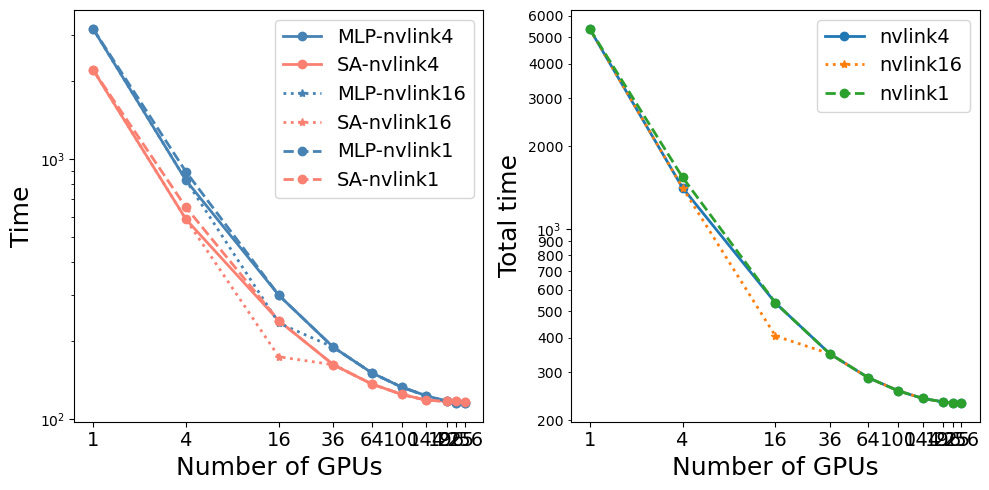

In [8]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 16, 36, 64, 100, 144, 196, 225, 256]
with open('config.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 4
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")

In [12]:
def set_gpus(n, nvs):
    parallelism = {}
    topology = {}
    factors_of_n = [[i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0]
    best_factor = factors_of_n[-1]
    parallelism['m1'] = best_factor[0]
    parallelism['m2'] = best_factor[1]
    
    if n <= nvs:
        # set all gpus within nvlink
        topology['t1'] = 'nvlink'
        topology['t2'] = 'nvlink'
    else:
        topology['t2'] = 'ib'
        topology['t1'] = 'nvlink' if parallelism['m2'] <= nvs else 'ib'
        
    # print(parallelism, topology)
    return parallelism, topology

def plot_2d(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        parallelism, topology = set_gpus(n, system['nvlink_size'])
        
        df_mlp = mlp_2d(b, l, e, f, depth, parallelism=parallelism, topology=topology)
        df_sa = sa_2d(b, l, e, h, depth, parallelism=parallelism, topology=topology)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() * depth)
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum() * depth)
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

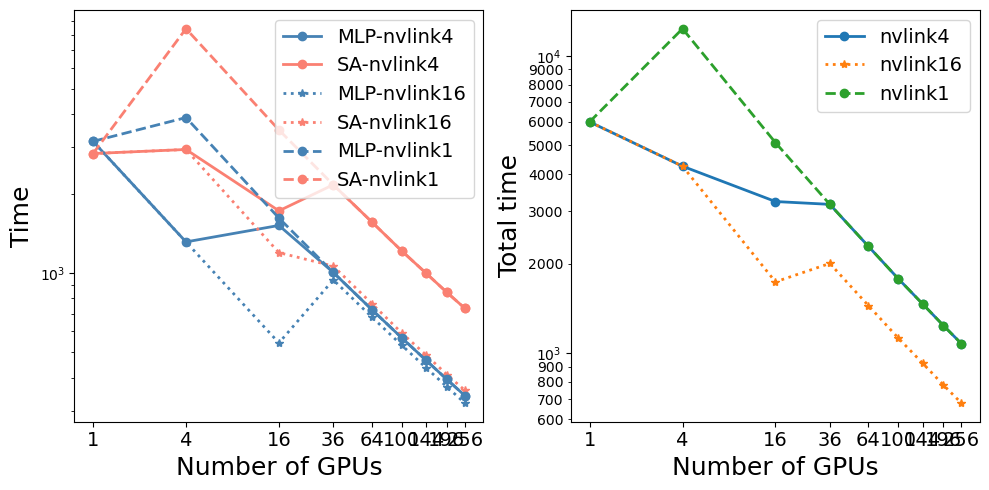

In [14]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 16, 36, 64, 100, 144, 196, 256]
with open('config.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

lgnd = []
lgnd_tot = []
nvs = 4
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")